https://www.tensorflow.org/tutorials/structured_data/time_series

# Time series forecasting

This tutorial is an introduction to time series forecasting using TensorFlow.  
It builds a few different styles of models inclluding Convolutional and   
Recurrent Neural Networks (CNNs and RNNs).

This is covered in two main parts, with subsections:
- Forecast for a single time step:
  - A single feature.
  - All features.
- Foreacst multiple steps
  - Single-shot: Make the predictions all at once.
  - Autoregressive: Make one prediction at a time and feed the output back to 
    the model.

## Setup

In [3]:
import os 
import datetime 

import IPython
import IPython.display
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf 


2023-11-18 06:34:07.903133: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-18 06:34:16.545084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

## The weather dataset

This tutorial uses a [weather time series dataset](https://www.bgc-jena.mpg.de/wetter/) 
recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/).

This dataset contains 14 different features such as air temperature, atmospheric pressure,  
and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency,   
you will use only the data collected between 2009 and 2016. This section of the dataset   
was prepared by François Chollet for his book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

In [5]:
zip_path = tf.keras.utils.get_file(
  origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip", 
  fname="jena_climate_2009_2016.csv.zip",
  extract=True
)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 16s 1us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling   
the data from 10-minute intervals to one-hour intervals:

In [30]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")

Let's take a glance at the data. Here are the first few rows:

In [31]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

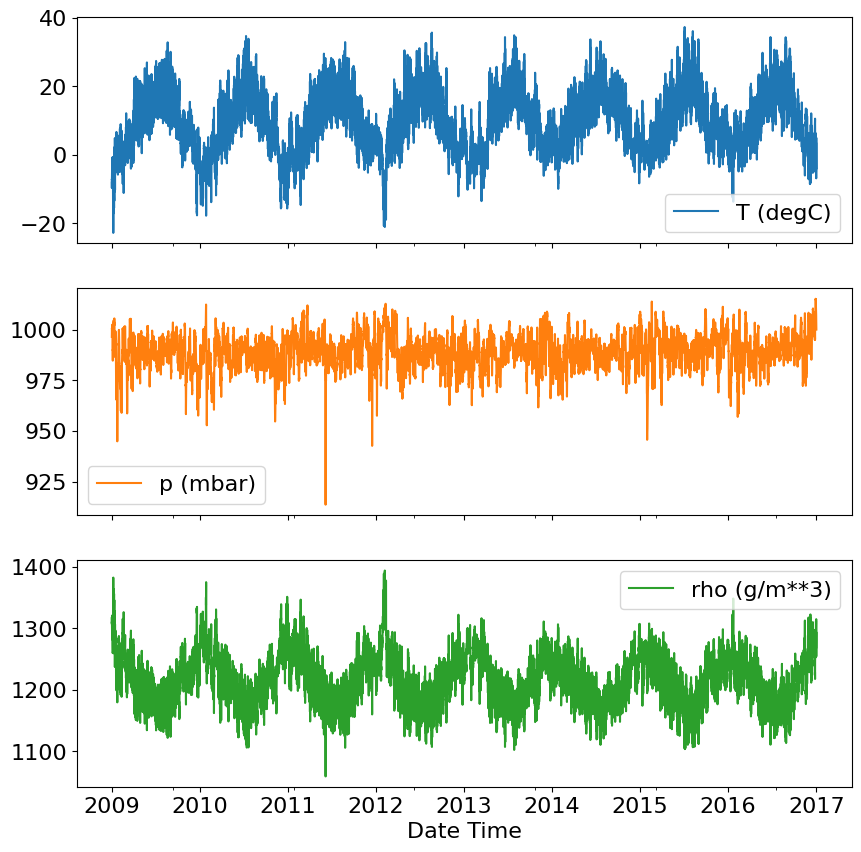

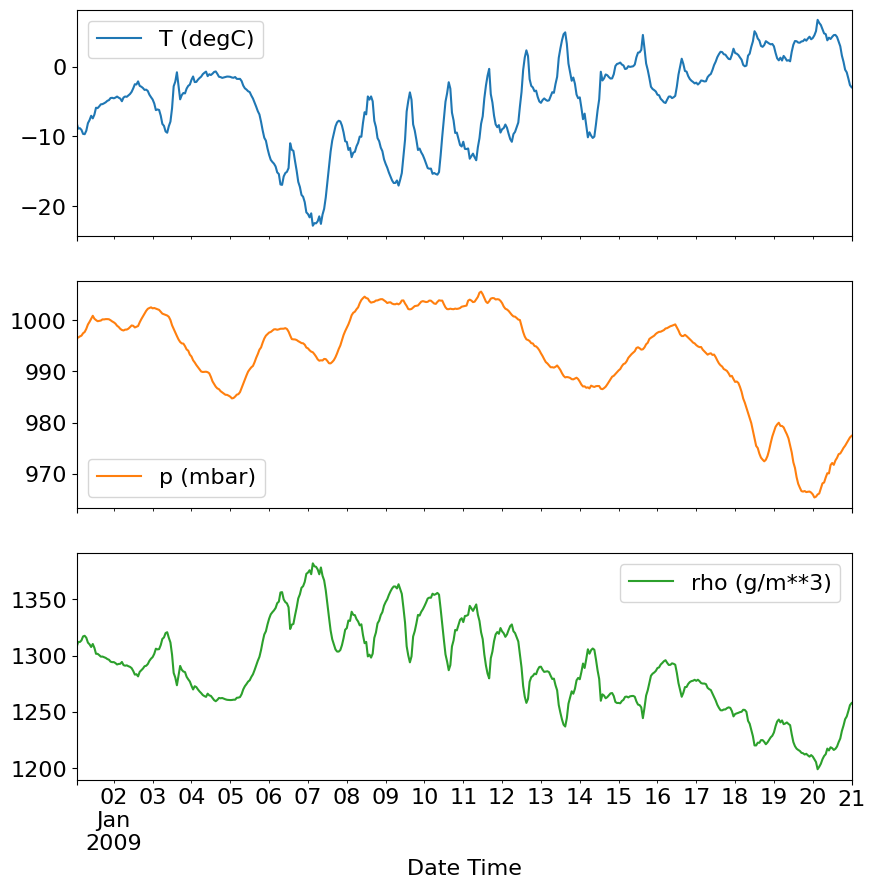

In [32]:
plot_cols = ["T (degC)", "p (mbar)", "rho (g/m**3)"]
plot_features = df[plot_cols]
plot_features.index = date_time

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
_ = plot_features.plot(subplots=True, ax=ax)
plt.show(fig)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, ax=ax)
plt.show(fig)

### Inspect and cleanup

Next, look at the statistics of the dataset:

In [35]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


**Wind velocity**

One thins that should stand out is the `min` value of the wind velocity   
(`wv (m/s)`) and the maximum value (`max, wv (m/s)`) columns. This `-9999`  
is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than  
zero (`>=0`). Replace it with zeros:

In [36]:
# we copy the DataFrame df, to avoid auto update to df and make each cell
# to be independent of each others.
df_clean = df.copy()
wv = df_clean["wv (m/s)"]
bad_wv = abs(wv - (-9999.0)) < 1e-6
wv[bad_wv] = 0.0

max_wv = df_clean["max. wv (m/s)"]
bad_max_wv = abs(max_wv - (-9999.0)) < 1e-6
max_wv[bad_max_wv] = 0.0

df_clean["wv (m/s)"].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be   
sure that you're passing the model appropriately formatted data.

**Wind**  

The last column of the data, `wd (deg)`&ndash;gives the wind direction in units of   
degrees. Angles do not make good modle input: 360&deg; and 0&deg; should be   
close to each other and wrap around smoothly. Direction shouldn't matter if the wind  
is not blowing.

Right now the distribution of wind data looks like this:

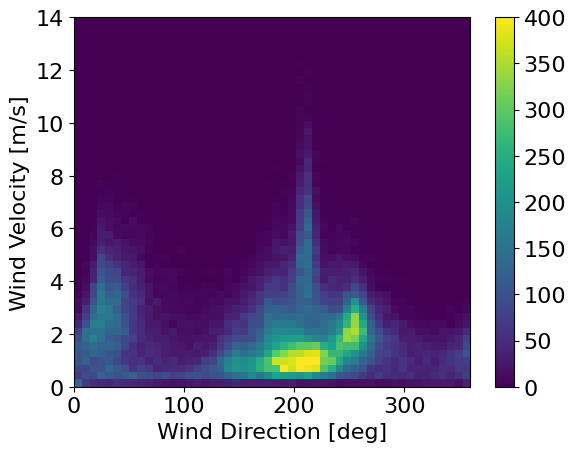

In [45]:
fig, ax = plt.subplots()

hist2d = ax.hist2d(df_clean["wd (deg)"], df_clean["wv (m/s)"], bins=(50, 50), vmax=400)

fig.colorbar(hist2d[3], ax=ax)   # the four elements of hist2d is QuadMesh
ax.set_xlabel("Wind Direction [deg]")
ax.set_ylabel("Wind Velocity [m/s]")


plt.show(fig)

But this will be easier for the model to interpret if you convert the wind direction  
and velocity columns to a wind **vector**:

In [49]:
df_clean_wv_vec = df_clean.copy()

wv = df_clean_wv_vec.pop("wv (m/s)")
max_wv = df_clean_wv_vec.pop("max. wv (m/s)")

# Convert to radians
wd_rad = df_clean_wv_vec.pop("wd (deg)") * np.pi / 180

# Calculate the wind x and y components
df_clean_wv_vec["Wx"] = wv*np.cos(wd_rad)
df_clean_wv_vec["Wy"] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components
df_clean_wv_vec["max Wx"] = max_wv*np.cos(wd_rad)
df_clean_wv_vec["max Wy"] = max_wv*np.sin(wd_rad)

df_clean_wv_vec

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy
5,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503
11,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645
17,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576
23,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090
29,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,-0.855154,-0.160038,-1.336792,-0.250174
420527,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,-0.716196,-0.726267,-1.348134,-1.367090
420533,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,-0.661501,0.257908,-1.453438,0.566672
420539,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,-0.280621,-0.209169,-0.545207,-0.406385


The distribution of wind vectors is much simpler for the model to correctly interpret:

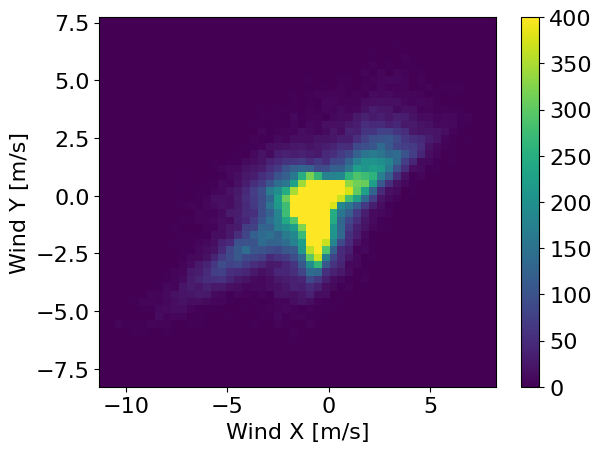

In [50]:
fig, ax = plt.subplots()

hist2d = ax.hist2d(df_clean_wv_vec["Wx"], df_clean_wv_vec["Wy"], bins=(50, 50), vmax=400)

fig.colorbar(hist2d[3], ax=ax)   # the four elements of hist2d is QuadMesh
ax.set_xlabel("Wind X [m/s]")
ax.set_ylabel("Wind Y [m/s]")


plt.show(fig)


**Time**   

Similarly, the `Date Time` column is very useful, but not in this string form.  
Start by converting it to seconds:


In [51]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

5         1.230772e+09
11        1.230775e+09
17        1.230779e+09
23        1.230782e+09
29        1.230786e+09
              ...     
420521    1.483211e+09
420527    1.483215e+09
420533    1.483219e+09
420539    1.483222e+09
420545    1.483226e+09
Name: Date Time, Length: 70091, dtype: float64

Similarly to the wind direction, the time in seconds is not a useful model input.  
Being weather data, it has clear daily and yearly periodicity. There are many ways  
you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear   
"Time of day" and "Time of year" signals:

In [57]:
day = 24*60*60
year = 365.2425*day

df_clean_wv_vec["Day sin"] = np.sin(timestamp_s * 2*np.pi/day)
df_clean_wv_vec["Day cos"] = np.cos(timestamp_s * 2*np.pi/day)
df_clean_wv_vec["Year sin"] = np.sin(timestamp_s * 2*np.pi/year)
df_clean_wv_vec["Year cos"] = np.cos(timestamp_s * 2*np.pi/year)

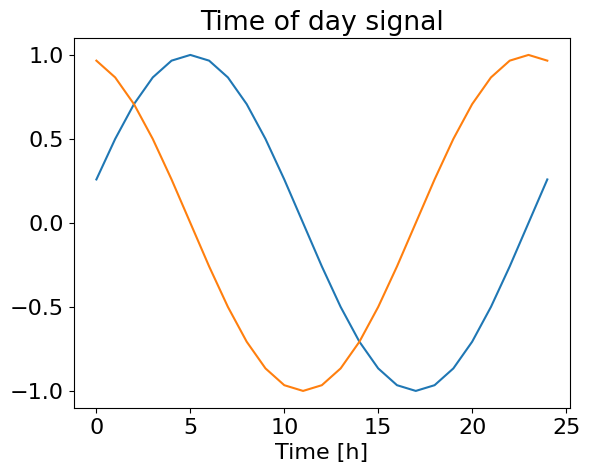

In [60]:
fig, ax = plt.subplots()

ax.plot(df_clean_wv_vec["Day sin"].to_numpy()[:25])
ax.plot(df_clean_wv_vec["Day cos"].to_numpy()[:25])

ax.set_xlabel("Time [h]")
ax.set_title("Time of day signal")

plt.show(fig)

This gives the model access to the most important frequency features. In this  
case you knew ahead of time which frequencies were important.   

If you don't have that information, you can determine which frequencies are   
important by extracting features with [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform).  
To check the assumptions, here is the `tf.signal.rfft` of the temperarture   
over time. Note the obvious peaks at frequencies near `1/year` and `1/day`

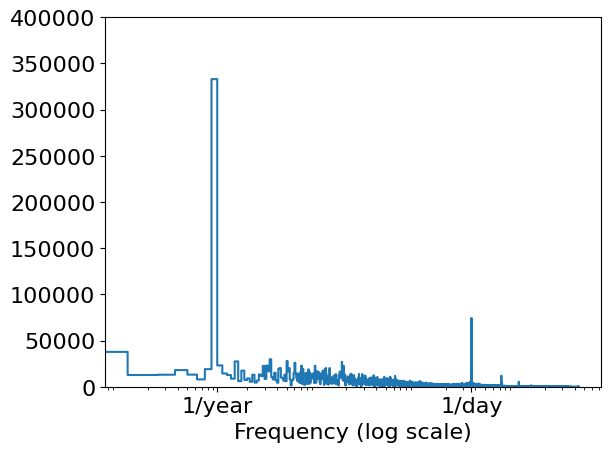

In [68]:
fft = tf.signal.rfft(df_clean_wv_vec["T (degC)"])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_clean_wv_vec["T (degC)"])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/hours_per_year

f_per_year = f_per_dataset/years_per_dataset

fig, ax = plt.subplots()

ax.step(f_per_year, np.abs(fft))
ax.set_xscale("log")
ax.set_ylim(0, 400_000)
ax.set_xticks([1, 365.2524], labels=["1/year", "1/day"])
ax.set_xlabel("Frequency (log scale)")

plt.show(fig)

### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets.   
Note the data is **not** being randomly shuffled before splitting. This is for   
two reasons:
1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated  
   on the data collected after the model was trained.

In [71]:
column_indices = {name: i for i, name in enumerate(df_clean_wv_vec.columns)}

n = len(df_clean_wv_vec)
train_val_split_idx = int(n*0.7)
val_test_split_idx = int(n*0.9)
train_df = df_clean_wv_vec[:train_val_split_idx]
val_df = df_clean_wv_vec[train_val_split_idx:val_test_split_idx]
test_df = df_clean_wv_vec[val_test_split_idx:]

num_features = df_clean_wv_vec.shape[1]
num_features

19

### Normalize the data

It is important to scale features before training a neural network.   
Normalization is a common way of doing this scaling: subtract the mean and divide  
by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data  
so that the models have no access to the values in the validation and test sets.  

It's also arguable that the model shouldn't have access to future values in   
the training, and that this normalization should be done using moving averages.  
That's not the focus this tutorial, and the validation and test sets ensures that  
you get (somewhat) honest metric. So, in the interest of simplicity this tutorial  
uses a simple average.

In [72]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df_normalized = (train_df - train_mean) / train_std
val_df_normalized = (val_df - train_mean) / train_std
test_df_normalized = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails,  
but there are no obvious errors like the `-9999` wind velocity value.

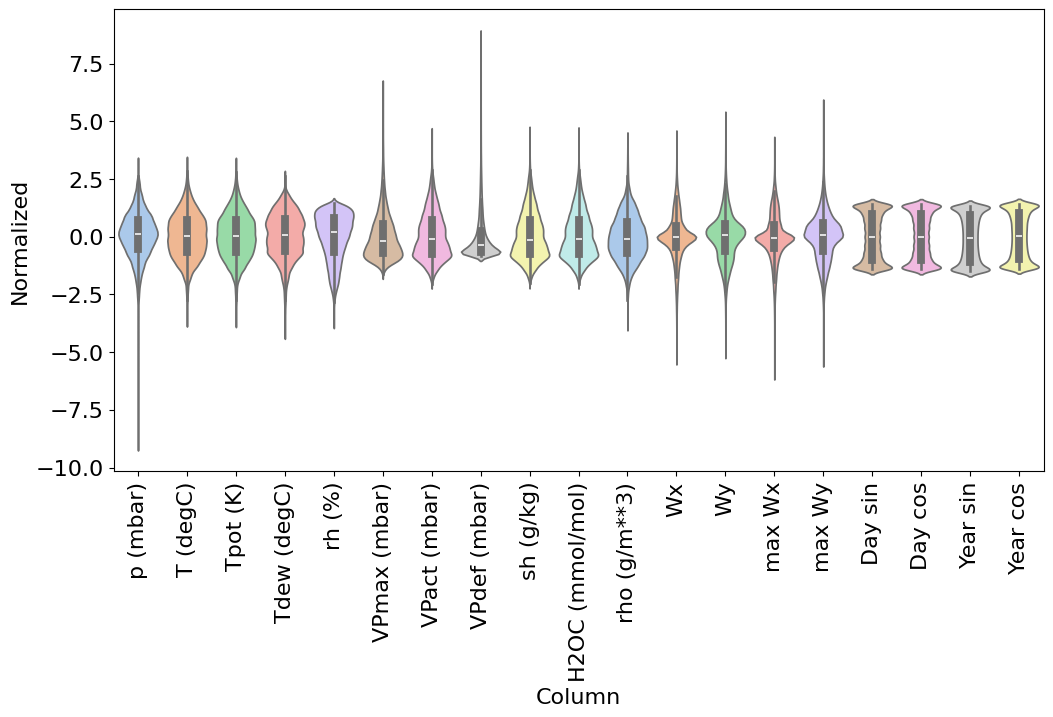

In [96]:
df_std = (df_clean_wv_vec - train_mean) / train_std

df_std = df_std.melt(var_name="Column", value_name="Normalized")
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(x="Column", hue="Column", y="Normalized", data=df_std, ax=ax, palette="pastel", legend=False)

ax.set_xticks(np.arange(len(df_clean_wv_vec.columns)))
ax.set_xticklabels(df_clean_wv_vec.keys(), rotation=90)
plt.show(fig)


# Using matplotlib takes forever
# fig, ax = plt.subplots()
# ax.violinplot(df_std.values.T) 

## Data windowing

The models in this tutorial will make a set of predictions based on a window of   
consecutive samples from the data.  

The main features of the input windows are:
- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models),   
and uses them for both:
- _Single-output_, and _multi-output_ predictions.
- _Single-time-step_ and _multi-time-step_ predictions.

This section focuses on implementing the data windowing so that it can be reused   
for all of those models.

Depending on the task and type of model you may want to generate a variety of data  
windows. Here are some examples:
1. For example, to make a single prediction 24 hours into the future, given   
   24 hours of history, you might define a window like this: <br>
   ![raw_window_24h.png](./raw_window_24h.png)

2. A model that makes a prediction one hour into the future, given six hours of   
   history, would need a window like this: <br>
   ![raw_window_1h.png](./raw_window_1h.png)

The rest of this section defines a `WindowGenerator` class. This class can:
1. Handle the indexes and offsets as shown in the diagram above.
2. Split windows of features into `(features, labels)` pairs.  
3. Plot the content of the resulting windows.
4. Efficiently generate batches of these windows from the training, evaluation,   
   and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGeneraator` class. The `__init__` method includes   
all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will  
be converted to `tf.data.Dataset`s of window later.

In [97]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift, 
                train_df=train_df, val_df=val_df, test_df=test_df, 
                label_columns=None):
    # Store the raw data.
    self.train_df = train_df 
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.  
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in 
                                    enumerate(label_columns)}

    self.column_indices = {name: i for i, name in 
                            enumerate(train_df.columns)}
    
    # Work out the window parameters.
    self.input_width = input_width 
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.label_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.label_slice]

  def __repr__(self):
    return "\n".join([
      f"Total window size: {self.total_window_size}", 
      f"Input indices: {self.input_indices}",
      f"Label indices: {self.label_indices}",
      f"Label column name(s): {self.label_columns}" 
    ])